In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

# from matplotlib import rcParam
import seaborn as sb
import os
import sys

sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad
from bg_atlasapi import BrainGlobeAtlas
from final_processing import final_processing_functions as fpf
import ast
%matplotlib inline


/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_proces

In [12]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache


mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [27]:
#take AP position of cubelets containing visual cortex (and also specifically V1)
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
AP_position_dict = {}
AP_cond_prob_dict = {}
for mouse in mice:
    new_dict = {}
    cond_prob_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=parameters['lcm_directory'],
        area_threshold=0.3,
    )
    V1_containing = areas_only_grouped[areas_only_grouped['VISp']>0].index.to_list()
    lcm_directory = pathlib.Path(parameters['lcm_directory'])
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    for sample in V1_containing:
        if sample in barcodes.columns:
            centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
            new_dict[sample] = centroid[0]-AP_midpoint_VIS
            filtered_bc = barcodes[barcodes[sample]>0]
            filtered_bc.drop(columns=[sample], inplace=True)
            filtered_with_area = fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = filtered_bc, cortical=True, shuffled=False, IT_only=True)
            cond_prob_dict[sample] = filtered_with_area.astype(bool).mean(axis=0)
    AP_position_dict[mouse] = new_dict
    AP_cond_prob_dict[mouse] = cond_prob_dict
#for each mouse, given that a cubelet is in a particular AP position, what are the probablity of targeting other areas?

/tmp/ipykernel_7639/3476914705.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bc.drop(columns=[sample], inplace=True)
/tmp/ipykernel_7639/3476914705.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bc.drop(columns=[sample], inplace=True)
/tmp/ipykernel_7639/3476914705.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bc.drop(columns=[sample], inplace=True)
/tmp/ipykernel_7639/3476914705.py:28: Se

Processing correlations for mouse: FIAA45.6a
Correlations for FIAA45.6a:
ACAd     -0.244859
ACAv     -0.291432
AUDd     -0.471688
AUDp     -0.143878
AUDpo    -0.011114
AUDv     -0.153187
ECT      -0.097646
HPF       0.371812
MOp      -0.308444
MOs       0.398259
PERI      0.211473
RSPagl   -0.202486
RSPd      0.448286
SSp      -0.865624
SSs      -0.826711
STR       0.209135
TEa       0.788159
VISC     -0.563376
VISa     -0.516315
VISal     0.409737
VISam    -0.204536
VISl      0.465818
VISli     0.156309
VISp     -0.130912
VISpl     0.321989
VISpm     0.307067
VISpor    0.787847
VISrl    -0.439673
Contra   -0.118543
Name: AP_Position, dtype: float64
Processing correlations for mouse: FIAA45.6d
Correlations for FIAA45.6d:
ACAd     -0.589975
ACAv     -0.589975
AUDd     -0.453302
AUDp     -0.537765
AUDpo    -0.271908
AUDv     -0.369981
ECT       0.001947
HPF      -0.200546
MOp      -0.142789
MOs      -0.514274
PERI      0.060264
PL             NaN
RSPagl    0.156190
RSPd      0.165096
RSP

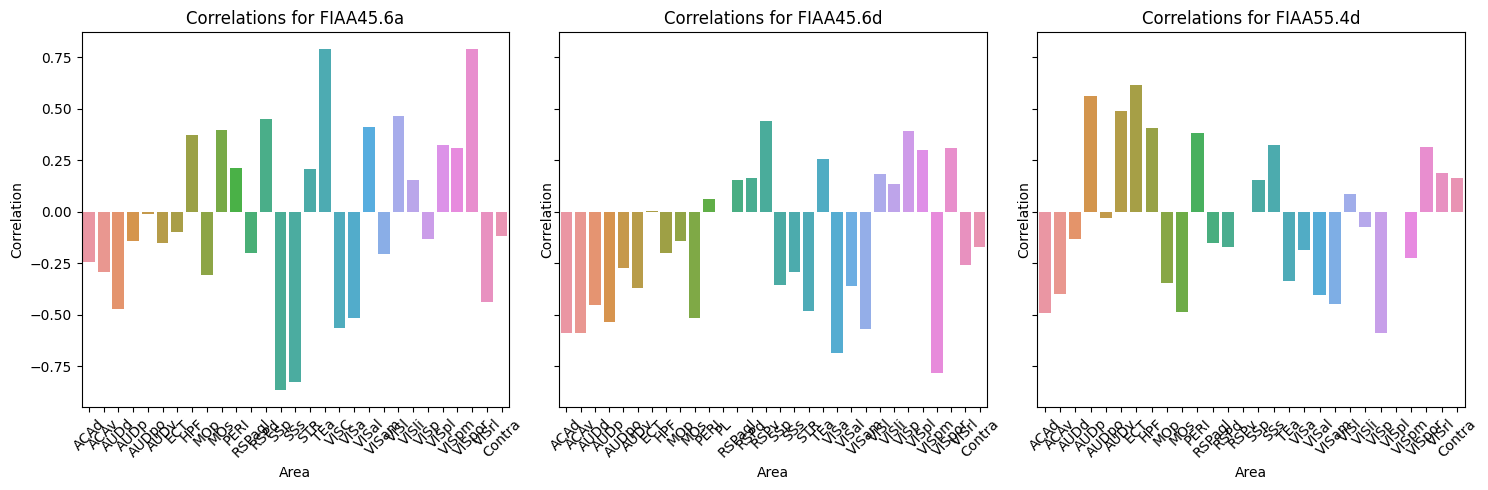

In [28]:
correlation_results = {}

for mouse in mice:
    print(f"Processing correlations for mouse: {mouse}")
    
    # Retrieve the conditional probabilities and AP positions for the mouse
    cond_prob = AP_cond_prob_dict[mouse]  # Conditional probabilities
    ap_positions = AP_position_dict[mouse]  # AP positions
    
    # Combine the data into a single DataFrame
    cond_prob_df = pd.DataFrame.from_dict(cond_prob, orient='index')  # Conditional probabilities as DataFrame
    ap_position_series = pd.Series(ap_positions, name='AP_Position')  # AP positions as Series
    
    # Merge AP positions with conditional probabilities
    combined_df = cond_prob_df.join(ap_position_series)
    
    # Calculate correlations between AP positions and each area's conditional probabilities
    correlations = combined_df.corr()['AP_Position'].drop('AP_Position')  # Drop self-correlation
    
    # Store the results
    correlation_results[mouse] = correlations

    # Display the results
    print(f"Correlations for {mouse}:")
    print(correlations)

# If needed, visualize the correlations
import matplotlib.pyplot as plt
import seaborn as sb

fig, axes = plt.subplots(1, len(mice), figsize=(15, 5), sharey=True)

for idx, mouse in enumerate(mice):
    sb.barplot(
        x=correlation_results[mouse].index,
        y=correlation_results[mouse].values,
        ax=axes[idx]
    )
    axes[idx].set_title(f"Correlations for {mouse}")
    axes[idx].set_xticklabels(correlation_results[mouse].index, rotation=45)
    axes[idx].set_ylabel("Correlation")
    axes[idx].set_xlabel("Area")

plt.tight_layout()
plt.show()

In [ ]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
common_columns = set(all_bc_dict['FIAA45.6a'].columns).intersection(
    set(all_bc_dict['FIAA45.6d'].columns)
).intersection(
    set(all_bc_dict['FIAA55.4d'].columns)
)
common_cols_cortex = []
for col in common_columns:
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
    if col == 'Contra':
        common_cols_cortex.append(col)

In [ ]:
combined_data = []

for mouse in mice:
    # Retrieve the conditional probabilities and AP positions for the mouse
    cond_prob = AP_cond_prob_dict[mouse]  # Conditional probabilities
    ap_positions = AP_position_dict[mouse]  # AP positions

    # Create a DataFrame for the mouse
    cond_prob_df = pd.DataFrame.from_dict(cond_prob, orient='index')  # Conditional probabilities
    ap_position_series = pd.Series(ap_positions, name='AP_Position')  # AP positions
    
    # Merge AP positions with conditional probabilities
    combined_df = cond_prob_df.join(ap_position_series)
    combined_df['Mouse'] = mouse  # Add mouse identifier
    combined_data.append(combined_df)

# Combine all mice into a single DataFrame
all_data = pd.concat(combined_data)

# Statistical Analysis: Correlation and Significance Test
results = []

for area in common_cols_cortex:#HVA_cols:
    if area in all_data.columns:
        # Filter out rows with missing data for the area or AP_Position
        data = all_data[['AP_Position', area]].dropna()
        
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data['AP_Position'], data[area])
        
        # Store the results
        results.append({'Area': area, 'Correlation': correlation, 'P-Value': p_value})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display significant results (e.g., P-Value < 0.05)
significant_results = results_df[results_df['P-Value'] < 0.05]
print("Significant Correlations:")
print(significant_results)

plt.figure(figsize=(10, 6))
sb.barplot(data=results_df, x='Area', y='Correlation', palette='coolwarm')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Correlations Between AP Position and Area Conditional Probabilities")
plt.xlabel("Area")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Filter out NaN values for the selected area
data = all_data[['AP_Position', 'VISa', 'Mouse']].dropna()

# Calculate correlation and p-value
correlation, p_value = pearsonr(data['AP_Position'], data['VISa'])

# Create the scatterplot with best-fit line
plt.figure(figsize=(8, 6))
sb.scatterplot(x='AP_Position', y='VISa', hue='Mouse', data=data, palette='Set2', s=50)

# Add a best-fit line using seaborn's regplot (no hue for a single line)
sb.regplot(x='AP_Position', y='VISa', data=data, scatter=False, color='black', ci=None)

# Annotate the correlation and p-value in the top-right corner
plt.text(
    data['AP_Position'].max() * 0.9,  # x-coordinate
    data['VISa'].max() * 0.9,       # y-coordinate
    f"r = {correlation:.2f}\np = {p_value:.2g}", 
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Add labels and title
plt.xlabel("AP Position")
plt.ylabel("Conditional Probability")
plt.title("P targeting VISa | VISp AP position")
plt.legend(title="Mouse", loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

[3, 4, 16, 17, 19, 35, 38, 39, 40, 50, 51, 56, 69, 70, 78]

In [ ]:


# Filter out NaN values for the selected area
data = all_data[['AP_Position', 'VISpor', 'Mouse']].dropna()

# Calculate correlation and p-value
correlation, p_value = pearsonr(data['AP_Position'], data['VISpor'])

# Create the scatterplot with best-fit line
plt.figure(figsize=(8, 6))
sb.scatterplot(x='AP_Position', y='VISpor', hue='Mouse', data=data, palette='Set2', s=50)

# Add a best-fit line using seaborn's regplot (no hue for a single line)
sb.regplot(x='AP_Position', y='VISpor', data=data, scatter=False, color='black', ci=None)

# Annotate the correlation and p-value in the top-right corner
plt.text(
    data['AP_Position'].max() * 0.8,  # x-coordinate
    data['VISpor'].max() * 0.9,       # y-coordinate
    f"r = {correlation:.2f}\np = {p_value:.2g}", 
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Add labels and title
plt.xlabel("AP Position")
plt.ylabel("Conditional Probability")
plt.title("P targeting VISpor | VISp AP position")
plt.legend(title="Mouse", loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()